In [1]:
import pickle
import sys
from sklearn.cluster import KMeans
sys.path.append('/home/ardelalegre/SoundMapping/Analysis/Util')
from get_time_interval_matrix_data import get_time_interval_matrix_data
from PCA import get_cdata
from PCA import get_eigen_vectors
from PCA import project_to_eigen_vectors
from Plot import plot_data
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
import glob
import os
import pandas as pd
import re
import json
import datetime
import time as timelib
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

'''
Define functions
'''
# Extract time information of each recording from the log file
def timeExtract(filename):
    with open(filename, 'rb') as f:
        # Start counting from the last byte
        counter = 1
        # Go to the 2nd byte before the end of the last line
        f.seek(-2, 2)
        while f.read(1) != b'\n':
            f.seek(-2, 1)
            counter = counter + 1
        endTime_line = f.readline().decode()
        # Go to the 2nd byte before the end of the last second line
        f.seek(-counter - 2, 2)
        while f.read(1) != b'\n':
            f.seek(-2, 1)
        startTime_line = f.readline().decode()

    return [startTime_line, endTime_line]

# Calculate duration of each recording in microseconds
def durationinMicroseconds(filename):
    startTime = timeExtract(filename)[0].split()[2:]
    endTime = timeExtract(filename)[1].split()[2:]
    startTimeStr = startTime[0] + ' ' + startTime[1]
    endTimeStr = endTime[0] + ' ' + endTime[1]
    T1 = datetime.datetime.strptime(startTimeStr, '%Y-%m-%d %H:%M:%S.%f')
    T2 = datetime.datetime.strptime(endTimeStr, '%Y-%m-%d %H:%M:%S.%f')
    delta = T2 - T1
    duration = delta.seconds * 1000000 + delta.microseconds

    return duration, T1, T2


# Converts .log files into pandas dataframes
def extractData(filename, arrayNum):
    with open(filename, 'r') as f:
        text = f.read()

    # Use repex to store blocks of data
    data = re.split('(?<=})\n(?={)', text)
    # Delete the time info from the last data block
    tmp = data[-1][:(data[-1].rfind("}") + 1)]
    data[-1] = tmp

    # Store each log block into a list
    srcList = [json.loads(block)["src"] for block in data]

    # Retrieve time information
    duration, startTime, endTime = durationinMicroseconds(filename)
    start_time_in_seconds = timelib.mktime(startTime.timetuple())
    t = duration / len(data) / 1000000.0

    data_list = []
    
    timestamp = 1 # Timestamp in log blocks starts at 1
    ind = 0
    for block in srcList:
        time_in_seconds = start_time_in_seconds + (timestamp - 1.0) * t
        data_list.append([timestamp, time_in_seconds,arrayNum,block[0]["x"],block[0]["y"],block[0]["z"]])
        ind = ind + 1
        timestamp = timestamp + 1
        
    return (np.array(data_list)),t

def foo(filename,arrayInd):
    data,t = extractData(filename,arrayInd)
    coor_sum = data[:,3]**2+data[:,4]**2+data[:,5]**2
    return data,t,coor_sum

def plot_timeseries(data,t,coor_sum,arrayInd):
    start = float(datetime.datetime.utcfromtimestamp(data[0,1]).strftime('%Y-%m-%d %H:%M:%S')[-2:])
    end = start+data.shape[0]*t
    time = np.arange(start,end,t)
    plt.figure(figsize=(24,7))
    plt.subplot(121)
    plt.plot(time, data[:,3], label = "x")
    plt.plot(time, data[:,4], label = "y")
    plt.plot(time, data[:,5], label = "z")
    plt.xlabel('time')
    plt.ylabel('value')
    plt.legend()
    plt.subplot(122)
    plt.plot(time, coor_sum)
    plt.suptitle("time series + on/off detection array {}".format(arrayInd))
    plt.show()
    
def plot_active(data,t,coor_sum):
    start = float(datetime.datetime.utcfromtimestamp(data[0,1]).strftime('%Y-%m-%d %H:%M:%S')[-2:])
    end = start+data.shape[0]*t
    time = np.arange(start,end,t)
    plt.plot(time,coor_sum)    
    

In [2]:
training_data = get_time_interval_matrix_data('Oct 13 2020 02:30PM', 'Oct 13 2020 02:40PM')

In [4]:
eigen_values_13, eigen_vectors_13 = get_eigen_vectors(training_data)
# with open ("model_13.pk","wb") as pk:
#     pickle.dump({"eigenvalues":eigen_values_13,"eigenvectors":eigen_vectors_13},pk)

In [6]:
# The eigen vectors loaded below are calculated from 10 mins on Oct 13th
model = pickle.load(open('model_13.pk','rb'))
eigen_val = model['eigenvalues']
eigen_vec = model['eigenvectors']

In [9]:
# Plot the time series for Oct 13th 2:30 - 2:35
# Obtain a list of files at 11:15
listOfFiles1  = glob.glob('/Users/yihanhu/Desktop/CSE4223/Data/10:13/SST 1430/*')
array0,t0,sum0 = foo(listOfFiles1[1],0)
array1,t1,sum1 = foo(listOfFiles1[2],1)
array2,t2,sum2 = foo(listOfFiles1[4],2)
array3,t3,sum3 = foo(listOfFiles1[3],3)
array5,t5,sum5 = foo(listOfFiles1[0],5)

# The following function plots the entire 5 minutes from 2:30 - 2:35
# The left figiure returns x,y,z values of each array against time, the right figure returns on/off detection of
# each array against time
plot_timeseries(array0,t0,sum0,0)
plot_timeseries(array1,t1,sum1,1)
plot_timeseries(array2,t2,sum2,2)
plot_timeseries(array3,t3,sum3,3)
plot_timeseries(array5,t5,sum5,5)

IndexError: list index out of range

In [ ]:
# Plot August data in PCA space
data_0819 = pickle.load(open('/home/ardelalegre/CSE4223-ODAS/preprocessing/python/aug 19/exp_08_19_better_data.p', 'rb'))
ind = [18]+[i for i in range(18)]
data_0819=data_0819[:,ind]

cdata_0819 = get_cdata(data_0819[187819:258785,:])
eigen_values_0819, eigen_vectors_0819 = get_eigen_vectors(data_0819)
projected_data_0819 = project_to_eigen_vectors(cdata_0819,2, eigen_values_0819, eigen_vectors_0819)
# plot_data(projected_data_0819)

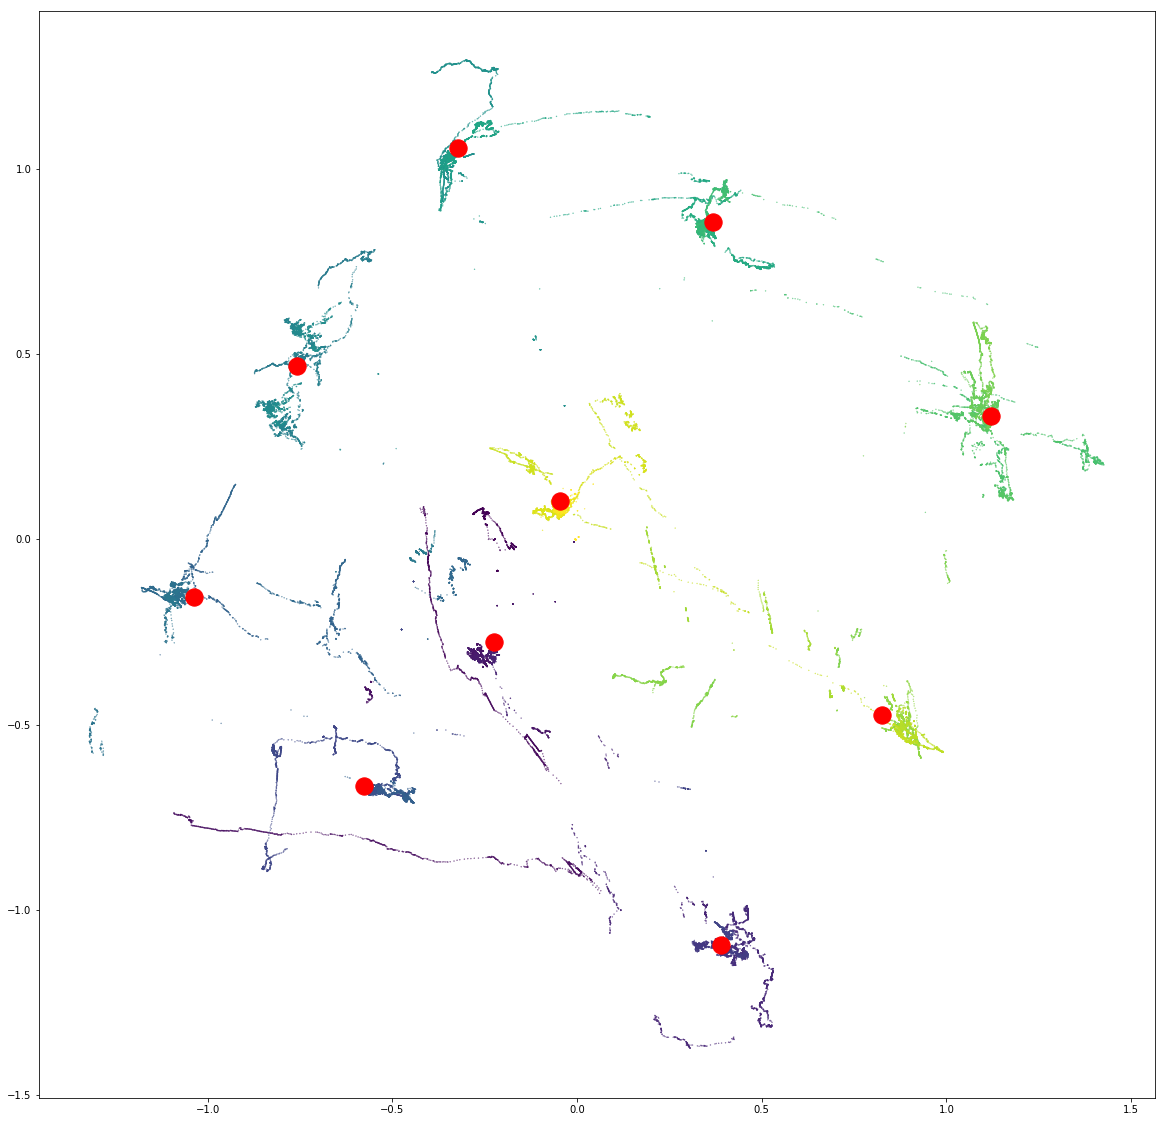

In [14]:
t = np.arange(len(projected_data_0819))
kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(projected_data_0819)
plt.figure(figsize=(20,20))
plt.scatter(projected_data_0819[:,0], projected_data_0819[:,1], s = .1, c = t, cmap="viridis")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
#plt.figure(figsize = (50,10))
plt.show()